# Zupee

**Problem Statement:**  
When a user logs in to the platform, they have to choose from a variety of tournament types (A / B / C / D). Additionally, different entry fees may be associated with every tournament. As a platform we must ensure that the most relevant tournaments are suggested to the user based on their preferences.

**Available Data:**  
You will be given anonymised user gameplay data in the form of 3 csv files. Fields in the data are as described below:
  
*`Gameplay_Data.csv`* contains following fields:
```
● Uid: Alphanumeric unique Id assigned to user
● Eventtime: DateTime on which user played the tournament
● Entry_Fee: Entry Fee of tournament
● Win_Loss: ‘W’ if the user won that particular tournament, ‘L’ otherwise
● Winnings: How much money the user won in the tournament (0 for ‘L’)
● Tournament_Type: Type of tournament user played (A / B / C / D)
● Num_Players: Number of players that played in this tournament
● OOT_holdout: True/False, True indicates the records for the solution evaluation*
*Do not use the Out-of-time holdout data for training
```
  
*`Wallet_Balance.csv`* contains following fields:
```
● Uid: Alphanumeric unique Id assigned to user
● Timestamp: DateTime at which user’s wallet balance is given
● Wallet_Balance: User’s wallet balance at given time stamp
```

*`Demographic.csv`* contains following fields:
```
● Uid: Alphanumeric unique Id assigned to user
● Installed_At: Timestamp at which user installed the app
● Connection_Type: User’s internet connection type (Ex: Cellular / Dial Up)
● Cpu_Type: Cpu type of device that the user is playing with
● Network_Type: Network type in encoded form
● Device_Manufacturer: Ex: Realme
● ISP: Internet Service Provider. Ex: Airtel
● Country
● Country_Subdivision
● City
● Postal_Code
● Language: Language that user has selected for gameplay
● Device_Name
● Device_Type
```

**Task:**  
Assume that there is a heuristic-based solution already in place that shows the last three user preferences as the top three choices (ordered by recency). Build a recommendation system that is able to rank/recommend relevant tournaments and entry prices to the user while outperforming the current solution in the Out-of-time holdout data -.
  
The main objectives are:  
1. A user should not have to scroll too much before selecting a tournament of their preference
2. We would like to move users to a higher entry fee whenever possible without having an adverse effect on the user experience  
  
As part of your solution, please include the following components:
```
● Code
● Documentation that outlines the solution approach, assumptions, success metrics, and
summary of final results
● Areas of improvement
```


## Loading Libs

In [1]:

## Initial Lib
import os
import time
from datetime import datetime
import pandas as pd
import pkg_resources
import geopandas as gpd  # installed this using github source python3 setup.py install
# Importing fiona resulted in: No module named 'fiona'
# Importing pyogrio resulted in: No module named 'pyogrio' --> pip3 install pyogrio
import matplotlib.pyplot as plt 

## Custom Library
import amleet as aml



## System properties


In [2]:

_ = aml.SoftwareHardware.get_system_info(msg=True)


[Error] Unable to get output when running "psutil.cpu_freq()"
======================================== System Information ========================================
.
├── System Information
│   ├── Machine Name .. bcd0743ded8d.ant.amazon.com
│   ├── Oper. System .. macOS-12.6.2-arm64-arm-64bit
│   ├── Version ....... Darwin Kernel Version 21.6.0: Sun Nov  6 23:31:13 PST 2022; root:xnu-8020.240.14~1/RELEASE_ARM64_T6000
│   ├── System ........ Darwin
│   ├── Release ....... 21.6.0
│   ├── Machine ....... arm64
│   ├── Processor ..... arm
│   └── Py Version .... 3.9.6
├── Time
│   ├── Current Time
│   │   ├── Timestamp ..... 1678095058.9
│   │   └── Date/Time ..... 2023/3/6 15:0:58
│   ├── Boot Time
│   │   ├── Timestamp ..... 1677669888.0
│   │   └── Date/Time ..... 2023/3/1 16:54:48
│   └── Uptime Time
│       ├── Seconds ....... 425170.9
│       └── Date/Time ..... 4 day, 22 hr, 6 min, 10 sec, 900.0 ms
├── CPU
│   ├── Cores
│   │   ├── Physical ...... 10
│   │   └── Total ......... 10
│ 

## Configurations

In [3]:
## File Path
gamep_path = './data/new/Gameplay_Data.csv'
balan_path = './data/new/Wallet_Balance.csv'
demog_path = './data/new/Demographic.csv'

cities_states_path = pkg_resources.resource_filename('amleet', 'aml_files/shp_files/india_cities_states_feb_2015.csv')
shp_states_path = pkg_resources.resource_filename('amleet', 'aml_files/shp_files/india_states/Indian_states.shp')

## Which Timezone to use
tz_use = 'Asia/Kolkata'


## Reading dataset & doing basic transformation

In [4]:
def shp_and_disp(df, varname):
    print('\n'+'-'*100)
    print('VarName\t:', varname)
    print('Shape\t:', df.shape)
    print('Columns\t:', list(df.columns))
    display(df.head())

## ------------------------------------------<< Gameplay >>------------------------------------------ ##

## 1. GamePlay >>>>> User engagement data
gamep_df = pd.read_csv(gamep_path)
gamep_df.rename(columns={k:k.strip().lower() for k in gamep_df.columns}, inplace=True)
gamep_df['eventtime'] = aml.OperationTime.timestamp_to_datetime(gamep_df['eventtime']/1000, timezone=tz_use)
gamep_df.drop(columns=['unnamed: 0'], inplace=True)
shp_and_disp(gamep_df, aml.variable_name_as_str(gamep_df))

## -------------------------------------------<< Balance >>------------------------------------------ ##

## 2.1. Balance DataFrame >>>>> user transaction data
balan_df = pd.read_csv(balan_path)
balan_df.rename(columns={k:k.strip().lower() for k in balan_df.columns}, inplace=True)
balan_df['timestamp'] = aml.OperationTime.to_datetime(balan_df['timestamp'], timezone=tz_use)
shp_and_disp(balan_df, aml.variable_name_as_str(balan_df))

## 2.2. Users Recent Balance >>>>> user account balance data
### create most recent balance 
curr_balance_path = 'proc_balance.csv'
# os.remove(curr_balance_path)
if os.path.exists(curr_balance_path):
    balan_rec_df = pd.read_csv(curr_balance_path)
    balan_rec_df['oldest_timestamp'] = aml.OperationTime.to_datetime(balan_rec_df['oldest_timestamp'], timezone=tz_use)
    balan_rec_df['recent_timestamp'] = aml.OperationTime.to_datetime(balan_rec_df['recent_timestamp'], timezone=tz_use)
else:
    existing_balance_li = []
    for uid in balan_df['uid'].unique():
        temp_df = balan_df.loc[balan_df['uid']==uid, :]
        uid_bal_di = {
            'uid': uid, 
            'oldest_timestamp': temp_df['timestamp'].min(), 
            'recent_timestamp': temp_df['timestamp'].max(), 
            'n_entries': len(temp_df),
            'no_transaction': True if len(temp_df)==1 else False,
            'wallet_balance_min': temp_df['wallet_balance'].min(),
            'wallet_balance_max': temp_df['wallet_balance'].max(),
            'wallet_balance_mean': temp_df['wallet_balance'].mean(),
            'wallet_balance_25quantile': temp_df['wallet_balance'].quantile(.25),
            'wallet_balance_median': temp_df['wallet_balance'].median(),
            'wallet_balance_75quantile': temp_df['wallet_balance'].quantile(.75),
            'wallet_balance_std': temp_df['wallet_balance'].std()
        }
        uid_bal_di['wallet_balance_recent'] = list(temp_df.loc[
            temp_df['timestamp']==uid_bal_di['recent_timestamp'], 'wallet_balance'
        ])[0]
        existing_balance_li.append(uid_bal_di)
    balan_rec_df = pd.DataFrame(existing_balance_li)
    balan_rec_df.loc[balan_rec_df['no_transaction'],'wallet_balance_std']=0
    balan_rec_df.to_csv(curr_balance_path, index=False)
shp_and_disp(balan_rec_df, aml.variable_name_as_str(balan_rec_df))


## -----------------------------------------<< Demographic >>---------------------------------------- ##

## 3.1. Demographic >>>>> user details
demog_df = pd.read_csv(demog_path)
demog_df.rename(columns={k:k.strip().lower() for k in demog_df.columns}, inplace=True)
demog_df['installed_at'] = aml.OperationTime.timestamp_to_datetime(demog_df['installed_at'], timezone=tz_use)
demog_df.drop_duplicates(inplace=True) # duplicate entries were observed
shp_and_disp(demog_df, aml.variable_name_as_str(demog_df))

## 3.2. Unique Demographic Data
print('Total Rows in demographic dataframe\t\t:', len(demog_df))
print('Total unique users in demographic dataframe\t:', len(demog_df['uid'].unique()))
demog_uid_cnt_df = pd.DataFrame(demog_df['uid'].value_counts()).reset_index().rename(columns={'index':'uid', 'uid':'#entries'})
duplicate_entried_uid_li = demog_uid_cnt_df.loc[demog_uid_cnt_df['#entries']>1,'uid'].values.tolist()
display(
    demog_df.loc[[e in duplicate_entried_uid_li for e in demog_df['uid']],:].sort_values(by=['uid']).head(10)
)
print('The reason for this change is difference is that the user has either logged in from different user or he/she has swithed from mode of network.')
### handing the duplicate UID 
'''
At the moment to keep data for UID unique; only the datapoint wrt to the UID that are most recent are being kept 
- bias introduced for the recent entry
'''
curr_demog_path = 'proc_demog.csv'
# os.remove(curr_demog_path)
if os.path.exists(curr_demog_path):
    demog_rec_df = pd.read_csv(curr_demog_path)
    demog_rec_df['installed_at'] = aml.OperationTime.to_datetime(demog_rec_df['installed_at'], timezone=tz_use)
else:
    ## time was order is not present based on user last usage; therefore in a way random
    demog_df = demog_df.sort_values(by=['uid', 'installed_at'])
    demog_rec_df = demog_df.drop_duplicates(subset=['uid'], keep='last').reset_index(drop=True)
    demog_rec_df.to_csv(curr_demog_path, index=False)
shp_and_disp(demog_rec_df, aml.variable_name_as_str(demog_rec_df))


## --------------------------------------<< IN Geography File >>------------------------------------- ##

## 4. Geography Shape File - External Source
shp_gdf = gpd.read_file(shp_states_path)
shp_and_disp(shp_gdf, aml.variable_name_as_str(shp_gdf))
# cities_states_df = pd.read_csv(cities_states_path)

## --------------------------------------<< User Merged Data >>-------------------------------------- ##

## 5. Performing Inner Join on Demog & Balance
user_merge_df = (
    demog_rec_df
        .rename(columns={k:f'dem_{k}' if k!='uid' else 'uid' for k in demog_rec_df.columns})
        .merge(
            balan_rec_df.rename(columns={k:f'bal_{k}'if k!='uid' else 'uid' for k in balan_rec_df.columns}), 
            on=['uid'], how='inner'
        )
)
shp_and_disp(user_merge_df, aml.variable_name_as_str(user_merge_df))





----------------------------------------------------------------------------------------------------
VarName	: gamep_df
Shape	: (307666, 8)
Columns	: ['uid', 'eventtime', 'entry_fee', 'win_loss', 'winnings', 'tournament_type', 'num_players', 'oot_holdout']


,uid,eventtime,entry_fee,win_loss,winnings,tournament_type,num_players,oot_holdout
0,90976392B3AA5DB94D134936B765879E,2020-12-07 04:10:30.194000+05:30,0.0,W,0.1,D,4,False
1,7457E894E1F7F1938E55802B964BDD27,2020-12-07 02:01:47.669000+05:30,10.0,W,17.0,A,2,False
2,52E43F75D7393581C4E2C5EDC7D24671,2020-12-04 00:51:02.845000+05:30,35.0,L,0.0,A,2,False
3,5736C06C66C6BC7036CCE9804F54A57C,2020-12-12 18:44:35.873000+05:30,10.0,W,32.0,B,4,False
4,5FE2DDA792CA72F731D818A5ECC5F1EB,2020-12-12 18:39:34.193000+05:30,25.0,W,42.0,A,2,False



----------------------------------------------------------------------------------------------------
VarName	: balan_df
Shape	: (545835, 3)
Columns	: ['uid', 'timestamp', 'wallet_balance']


,uid,timestamp,wallet_balance
0,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 11:58:44+05:30,10.0
1,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 12:02:19+05:30,20.0
2,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 12:02:38+05:30,10.0
3,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 12:04:05+05:30,20.0
4,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 12:04:37+05:30,15.0



----------------------------------------------------------------------------------------------------
VarName	: balan_rec_df
Shape	: (21757, 13)
Columns	: ['uid', 'oldest_timestamp', 'recent_timestamp', 'n_entries', 'no_transaction', 'wallet_balance_min', 'wallet_balance_max', 'wallet_balance_mean', 'wallet_balance_25quantile', 'wallet_balance_median', 'wallet_balance_75quantile', 'wallet_balance_std', 'wallet_balance_recent']


,uid,oldest_timestamp,recent_timestamp,n_entries,no_transaction,wallet_balance_min,wallet_balance_max,wallet_balance_mean,wallet_balance_25quantile,wallet_balance_median,wallet_balance_75quantile,wallet_balance_std,wallet_balance_recent
0,929A32AC6F614F29BEEA8601BDF0676C,2020-11-12 11:58:44+05:30,2020-11-14 17:08:58+05:30,44,False,1.0,39.0,18.022727,10.75,18.0,23.25,8.893396,1.0
1,08B4F6235FCE8FF788B2D5CFCC87E27A,2020-11-20 19:11:54+05:30,2020-11-20 19:11:54+05:30,1,True,10.0,10.0,10.000000,10.00,10.0,10.00,0.000000,10.0
2,7393DA09A262621BD04FB9DFEA02951D,2020-11-21 14:07:16+05:30,2020-11-21 14:07:16+05:30,1,True,10.0,10.0,10.000000,10.00,10.0,10.00,0.000000,10.0
3,29E16AE3813E360E52CF236899F4B30D,2020-11-27 05:25:09+05:30,2020-11-27 05:25:09+05:30,1,True,10.0,10.0,10.000000,10.00,10.0,10.00,0.000000,10.0
4,D302D8D9AF1B7F6F9ED08D575F103EAB,2020-11-28 08:41:54+05:30,2020-11-28 08:41:54+05:30,1,True,10.0,10.0,10.000000,10.00,10.0,10.00,0.000000,10.0



----------------------------------------------------------------------------------------------------
VarName	: demog_df
Shape	: (21452, 14)
Columns	: ['uid', 'installed_at', 'connection_type', 'cpu_type', 'network_type', 'device_manufacturer', 'isp', 'country', 'country_subdivision', 'city', 'postal_code', 'language', 'device_name', 'device_type']


,uid,installed_at,connection_type,cpu_type,network_type,device_manufacturer,isp,country,country_subdivision,city,postal_code,language,device_name,device_type
0,24CC6E6BA192D1A1EEB320E77F0BF2EE,2020-12-25 09:32:53+05:30,Cellular,arm64-v8a,0,Realme,Airtel,in,Karnataka,Bengaluru,560002,en,XT,phone
1,2762F8FB0C406E59DC9D665A4CCEE468,2020-12-25 09:35:17+05:30,Cellular,armeabi-v7a,0,Tecno,Jio,in,Bihar,Patna,800001,en,TECNOKD7h,phone
2,0CF35DBD42AC7013E1A295B5C8E78B0A,2020-12-25 09:37:05+05:30,Cellular,arm64-v8a,0,Xiaomi,Idea Cellular,in,Tamil Nadu,Chennai,600012,en,MiA3,phone
3,E829EB3C5A9890718794301564007D91,2020-12-25 09:38:01+05:30,Cellular,arm64-v8a,13,vivo,Vodafone India,in,Tamil Nadu,Salem,636007,en,vivo1820,phone
4,5BF3652D06CFAF7E811416F1647E597F,2020-12-25 09:39:39+05:30,Cellular,arm64-v8a,13,Oppo,Jio,in,National Capital Territory of Delhi,New Delhi,110008,en,A5s,phone


Total Rows in demographic dataframe		: 21452
Total unique users in demographic dataframe	: 21437


,uid,installed_at,connection_type,cpu_type,network_type,device_manufacturer,isp,country,country_subdivision,city,postal_code,language,device_name,device_type
16633,2BC9D9BA88F1DD48E16A27CC2425CF61,2020-08-05 17:16:40+05:30,Cable/DSL,arm64-v8a,0,Xiaomi,Excitel,in,National Capital Territory of Delhi,Delhi,110006,en,RedmiK20,phone
16625,2BC9D9BA88F1DD48E16A27CC2425CF61,2020-08-05 17:16:40+05:30,Cellular,arm64-v8a,0,Xiaomi,Airtel,in,National Capital Territory of Delhi,Delhi,110054,en,RedmiK20,phone
1841,32684C2DEB9691573EDC67C3E93B3449,2020-12-09 19:35:19+05:30,Cellular,arm64-v8a,13,vivo,Jio,in,West Bengal,Kolkata,700028,en,vivo1901,phone
5832,32684C2DEB9691573EDC67C3E93B3449,2020-12-09 19:35:19+05:30,Cellular,arm64-v8a,13,vivo,Jio,in,West Bengal,Kolkata,700059,en,vivo1901,phone
1426,41243E2847A9BD83AF9E3AE71A0FF0B5,2020-12-07 17:14:36+05:30,Cellular,armeabi-v7a,13,Samsung,Jio,in,Bihar,Patna,800020,en,GalaxyJ2Core,phone
1430,41243E2847A9BD83AF9E3AE71A0FF0B5,2020-12-07 17:14:36+05:30,Cellular,armeabi-v7a,13,Samsung,Jio,in,Bihar,Patna,800001,en,GalaxyJ2Core,phone
11376,414692E57C5090C5E236670A1E95235B,2020-12-08 20:03:19+05:30,Cellular,armeabi-v7a,13,Xiaomi,Idea Cellular,in,Madhya Pradesh,Indore,452001,en,9,phone
11374,414692E57C5090C5E236670A1E95235B,2020-12-08 20:03:19+05:30,Cellular,armeabi-v7a,13,Xiaomi,Idea Cellular,in,Madhya Pradesh,Bhopal,462030,en,9,phone
12849,492F5BD0E9F792FCF333B39694A5ACCD,2020-12-30 21:26:56+05:30,Cellular,arm64-v8a,13,95390fae98a24199,Airtel,in,National Capital Territory of Delhi,New Delhi,110008,en,42fa3b0e43be4e61,tablet
3726,492F5BD0E9F792FCF333B39694A5ACCD,2020-12-30 21:26:56+05:30,Cellular,arm64-v8a,13,95390fae98a24199,Idea Cellular,in,Uttarakhand,Ramnagar,244715,en,42fa3b0e43be4e61,tablet


The reason for this change is difference is that the user has either logged in from different user or he/she has swithed from mode of network.

----------------------------------------------------------------------------------------------------
VarName	: demog_rec_df
Shape	: (21437, 14)
Columns	: ['uid', 'installed_at', 'connection_type', 'cpu_type', 'network_type', 'device_manufacturer', 'isp', 'country', 'country_subdivision', 'city', 'postal_code', 'language', 'device_name', 'device_type']


,uid,installed_at,connection_type,cpu_type,network_type,device_manufacturer,isp,country,country_subdivision,city,postal_code,language,device_name,device_type
0,00024680E7379CABB31C1F07A424AB79,2020-12-18 10:04:46+05:30,Cable/DSL,arm64-v8a,0,Xiaomi,Mylink Services Pvt Ltd,in,National Capital Territory of Delhi,New Delhi,110001,en,Redmi6,phone
1,0002D2CB922C013AAD7B252BF4EFA83B,2020-12-28 20:31:31+05:30,Cellular,arm64-v8a,13,vivo,Jio,in,Rajasthan,Jaipur,302001,hi,vivo1904,phone
2,00033530318B671BDA6D7F32CE89A8DE,2020-12-24 14:48:14+05:30,Cellular,arm64-v8a,13,vivo,Airtel,in,Bihar,Banka,813109,en,vivo1906,phone
3,000396133A80FFC18828139623F9DF45,2020-12-20 07:47:13+05:30,Cellular,arm64-v8a,13,Xiaomi,Jio,in,Bihar,Patna,800001,en,Redmi3S,phone
4,0008CE5E7C84DF55C9887B3C95214681,2020-12-27 15:04:21+05:30,Cellular,armeabi-v7a,13,Samsung,Airtel,in,Rajasthan,Jodhpur,342001,en,GalaxyA2Core,phone



----------------------------------------------------------------------------------------------------
VarName	: shp_gdf
Shape	: (36, 2)
Columns	: ['st_nm', 'geometry']


,st_nm,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."



----------------------------------------------------------------------------------------------------
VarName	: user_merge_df
Shape	: (21428, 26)
Columns	: ['uid', 'dem_installed_at', 'dem_connection_type', 'dem_cpu_type', 'dem_network_type', 'dem_device_manufacturer', 'dem_isp', 'dem_country', 'dem_country_subdivision', 'dem_city', 'dem_postal_code', 'dem_language', 'dem_device_name', 'dem_device_type', 'bal_oldest_timestamp', 'bal_recent_timestamp', 'bal_n_entries', 'bal_no_transaction', 'bal_wallet_balance_min', 'bal_wallet_balance_max', 'bal_wallet_balance_mean', 'bal_wallet_balance_25quantile', 'bal_wallet_balance_median', 'bal_wallet_balance_75quantile', 'bal_wallet_balance_std', 'bal_wallet_balance_recent']


,uid,dem_installed_at,dem_connection_type,dem_cpu_type,dem_network_type,dem_device_manufacturer,dem_isp,dem_country,dem_country_subdivision,dem_city,...,bal_n_entries,bal_no_transaction,bal_wallet_balance_min,bal_wallet_balance_max,bal_wallet_balance_mean,bal_wallet_balance_25quantile,bal_wallet_balance_median,bal_wallet_balance_75quantile,bal_wallet_balance_std,bal_wallet_balance_recent
0,00024680E7379CABB31C1F07A424AB79,2020-12-18 10:04:46+05:30,Cable/DSL,arm64-v8a,0,Xiaomi,Mylink Services Pvt Ltd,in,National Capital Territory of Delhi,New Delhi,...,1,True,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0
1,0002D2CB922C013AAD7B252BF4EFA83B,2020-12-28 20:31:31+05:30,Cellular,arm64-v8a,13,vivo,Jio,in,Rajasthan,Jaipur,...,1,True,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0
2,00033530318B671BDA6D7F32CE89A8DE,2020-12-24 14:48:14+05:30,Cellular,arm64-v8a,13,vivo,Airtel,in,Bihar,Banka,...,1,True,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0
3,000396133A80FFC18828139623F9DF45,2020-12-20 07:47:13+05:30,Cellular,arm64-v8a,13,Xiaomi,Jio,in,Bihar,Patna,...,1,True,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0
4,0008CE5E7C84DF55C9887B3C95214681,2020-12-27 15:04:21+05:30,Cellular,armeabi-v7a,13,Samsung,Airtel,in,Rajasthan,Jodhpur,...,1,True,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0


## Checking for Missing Data

### GamePlay

In [5]:
all_na_df, spec_na_df  = aml.Analysis.check_for_missing_data(gamep_df, by=['tournament_type'])
all_na_df

,features,available_rows,missing_rows,total_rows,%missing
0,uid,307666,0,307666,0.0
1,eventtime,307666,0,307666,0.0
2,entry_fee,307666,0,307666,0.0
3,win_loss,307666,0,307666,0.0
4,winnings,307666,0,307666,0.0
5,tournament_type,307666,0,307666,0.0
6,num_players,307666,0,307666,0.0
7,oot_holdout,307666,0,307666,0.0


In [6]:
spec_na_df

uid eventtime entry_fee  \
                tournament_type total_rows %missing  %missing  %missing   
tournament_type                                                           
A                             A     180639      0.0       0.0       0.0   
B                             B       6862      0.0       0.0       0.0   
C                             C      27274      0.0       0.0       0.0   
D                             D      92891      0.0       0.0       0.0   

                win_loss winnings num_players oot_holdout  
                %missing %missing    %missing    %missing  
tournament_type                                            
A                    0.0      0.0         0.0         0.0  
B                    0.0      0.0         0.0         0.0  
C                    0.0      0.0         0.0         0.0  
D                    0.0      0.0         0.0         0.0

##### observations
- No Missing data here


### Balance

In [7]:
all_na_df, _  = aml.Analysis.check_for_missing_data(balan_df, by=['uid'])
all_na_df

,features,available_rows,missing_rows,total_rows,%missing
0,uid,545835,0,545835,0.0
1,timestamp,545835,0,545835,0.0
2,wallet_balance,545835,0,545835,0.0


##### observations
- No Missing data here


### Demographic

In [8]:
all_na_df, spec_na_df  = aml.Analysis.check_for_missing_data(demog_rec_df, by=['country'])
all_na_df

,features,available_rows,missing_rows,total_rows,%missing
10,postal_code,20860,577,21437,2.69
9,city,20885,552,21437,2.57
8,country_subdivision,21363,74,21437,0.35
6,isp,21427,10,21437,0.05
2,connection_type,21432,5,21437,0.02
12,device_name,21434,3,21437,0.01
0,uid,21437,0,21437,0.00
1,installed_at,21437,0,21437,0.00
3,cpu_type,21437,0,21437,0.00
4,network_type,21437,0,21437,0.00


In [9]:
spec_na_df

postal_code     city country_subdivision      isp  \
        country total_rows    %missing %missing            %missing %missing   
country                                                                        
ae           ae          2      100.00    50.00               50.00     0.00   
au           au          1        0.00     0.00                0.00     0.00   
ba           ba          1      100.00     0.00                0.00     0.00   
bd           bd         21       19.05    19.05               19.05     4.76   
ca           ca          1        0.00     0.00              100.00     0.00   
ch           ch          1        0.00     0.00                0.00     0.00   
cz           cz          1        0.00     0.00                0.00     0.00   
de           de          1        0.00     0.00                0.00     0.00   
fr           fr          3       66.67    66.67               66.67     0.00   
gb           gb          6       16.67    16.67               16.67     0.00   
ie           ie          1        0.00     0.00                0.00     0.00   
in           in      21331        2.57     2.51                0.23     0.04   
ir           ir          1      100.00   100.00              100.00     0.00   
kw           kw          1      100.00     0.00                0.00     0.00   
lk           lk          5        0.00     0.00                0.00     0.00   
mu           mu          1      100.00     0.00                0.00     0.00   
np           np          9      100.00    44.44               44.44     0.00   
pk           pk          7       28.57    28.57               14.29     0.00   
qa           qa          3      100.00     0.00                0.00     0.00   
sg           sg          8        0.00     0.00              100.00     0.00   
th           th          2        0.00     0.00                0.00     0.00   
tr           tr          1        0.00     0.00                0.00     0.00   
tt           tt          1      100.00     0.00                0.00     0.00   
us           us         27        0.00     0.00                0.00     0.00   
ye           ye          1      100.00   100.00              100.00     0.00   

        connection_type device_name      uid installed_at cpu_type  \
               %missing    %missing %missing     %missing %missing   
country                                                              
ae                 0.00        0.00      0.0          0.0      0.0   
au                 0.00        0.00      0.0          0.0      0.0   
ba                 0.00        0.00      0.0          0.0      0.0   
bd                 4.76        0.00      0.0          0.0      0.0   
ca                 0.00        0.00      0.0          0.0      0.0   
ch                 0.00        0.00      0.0          0.0      0.0   
cz                 0.00        0.00      0.0          0.0      0.0   
de                 0.00        0.00      0.0          0.0      0.0   
fr                 0.00        0.00      0.0          0.0      0.0   
gb                 0.00        0.00      0.0          0.0      0.0   
ie                 0.00        0.00      0.0          0.0      0.0   
in                 0.02        0.01      0.0          0.0      0.0   
ir                 0.00        0.00      0.0          0.0      0.0   
kw                 0.00        0.00      0.0          0.0      0.0   
lk                 0.00        0.00      0.0          0.0      0.0   
mu                 0.00        0.00      0.0          0.0      0.0   
np                 0.00        0.00      0.0          0.0      0.0   
pk                 0.00        0.00      0.0          0.0      0.0   
qa                 0.00        0.00      0.0          0.0      0.0   
sg                 0.00        0.00      0.0          0.0      0.0   
th                 0.00        0.00      0.0          0.0      0.0   
tr                 0.00        0.00      0.0          0.0      0.0   
tt                 0.00        0.00 

In [10]:
all_na_df, spec_na_df  = aml.Analysis.check_for_missing_data(demog_rec_df, by=['connection_type'])
spec_na_df


postal_code     city  \
                connection_type total_rows    %missing %missing   
connection_type                                                   
Cable/DSL             Cable/DSL       1431        1.40     0.77   
Cellular               Cellular      19915        2.73     2.65   
Corporate             Corporate         85       12.94    12.94   
Dialup                   Dialup          1        0.00     0.00   

                country_subdivision      isp device_name      uid  \
                           %missing %missing    %missing %missing   
connection_type                                                     
Cable/DSL                      0.49     0.14        0.14      0.0   
Cellular                       0.23     0.03        0.01      0.0   
Corporate                     23.53     0.00        0.00      0.0   
Dialup                         0.00     0.00        0.00      0.0   

                installed_at cpu_type network_type device_manufacturer  \
                    %missing %missing     %missing            %missing   
connection_type                                                          
Cable/DSL                0.0      0.0          0.0                 0.0   
Cellular                 0.0      0.0          0.0                 0.0   
Corporate                0.0      0.0          0.0                 0.0   
Dialup                   0.0      0.0          0.0                 0.0   

                 country language device_type  
                %missing %missing    %missing  
connection_type                                
Cable/DSL            0.0      0.0         0.0  
Cellular             0.0      0.0         0.0  
Corporate            0.0      0.0         0.0  
Dialup               0.0      0.0         0.0

In [11]:
all_na_df, spec_na_df  = aml.Analysis.check_for_missing_data(demog_rec_df, by=['device_type'])
spec_na_df


postal_code     city country_subdivision  \
            device_type total_rows    %missing %missing            %missing   
device_type                                                                   
phone             phone      21310        2.69     2.57                0.34   
tablet           tablet        126        3.17     3.17                0.79   
tv                   tv          1        0.00     0.00                0.00   

                 isp connection_type device_name      uid installed_at  \
            %missing        %missing    %missing %missing     %missing   
device_type                                                              
phone           0.05            0.02        0.01      0.0          0.0   
tablet          0.00            0.00        0.00      0.0          0.0   
tv              0.00            0.00        0.00      0.0          0.0   

            cpu_type network_type device_manufacturer  country language  
            %missing     %missing            %missing %missing %missing  
device_type                                                              
phone            0.0          0.0                 0.0      0.0      0.0  
tablet           0.0          0.0                 0.0      0.0      0.0  
tv               0.0          0.0                 0.0      0.0      0.0

### User Merged Data

In [12]:
all_na_df, spec_na_df  = aml.Analysis.check_for_missing_data(user_merge_df, by=['dem_country'])
all_na_df

,features,available_rows,missing_rows,total_rows,%missing
10,dem_postal_code,20851,577,21428,2.69
9,dem_city,20876,552,21428,2.58
8,dem_country_subdivision,21354,74,21428,0.35
6,dem_isp,21418,10,21428,0.05
2,dem_connection_type,21423,5,21428,0.02
12,dem_device_name,21425,3,21428,0.01
0,uid,21428,0,21428,0.00
16,bal_n_entries,21428,0,21428,0.00
24,bal_wallet_balance_std,21428,0,21428,0.00
23,bal_wallet_balance_75quantile,21428,0,21428,0.00


##### observations
- users are available across multiple countries
- Traffic comming from multiple other countries has few information that is absent at time
- Major portion of missing data is linked with connection_type "Corporate" 



## Exploratory Data Analysis

### GamePlay

##### Basic Analysis

In [13]:
df_info = aml.DataPrimAnalysis(gamep_df, True).run()


Overall dataset shape : (307666, 8)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,min,25%,50%,75%,max,%Missing
eventtime,0,datetime64,0,307666,2020-12-20 05:05:08.709910784+05:30,2020-12-01 06:14:50.137000+05:30,2020-12-14 03:42:23.841499904+05:30,2020-12-21 00:33:58.074500096+05:30,2020-12-27 09:48:24.194249984+05:30,2021-01-01 05:29:25.926000+05:30,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
uid,0,object,0,307666,10499,7457E894E1F7F1938E55802B964BDD27,1323,"[90976392B3AA5DB94D134936B765879E, 7457E894E1F...",0.0
win_loss,0,object,0,307666,2,W,168236,"[W, L]",0.0
tournament_type,0,object,0,307666,4,A,180639,"[D, A, B, C]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
entry_fee,0,float64,0,307666.0,14.161204,71.605218,0.0,1.0,1.0,10.0,10000.0,0.0
winnings,0,float64,0,307666.0,11.193157,79.794824,0.0,0.0,0.2,2.0,9000.0,0.0
num_players,0,int64,0,307666.0,2.825746,0.984702,2.0,2.0,2.0,4.0,4.0,0.0


Some columns data is missing b/c of data type
len(temp)!= (len(temp_tim) + len(temp_cat) + len(temp_num))
8 != (1 + 3+ 3)
Columns not part of this: ['oot_holdout']


##### BiVariate Analysis

In [14]:
aml.Analysis.value_counts_2_cols(gamep_df['tournament_type'], gamep_df['num_players'], True)


num_players,2,4
tournament_type,,
A,180639,
B,,6862
C,,27274
D,,92891


In [15]:
aml.Analysis.value_counts_2_cols(gamep_df['tournament_type'], gamep_df['entry_fee'], True)


entry_fee,0.0,1.0,5.0,10.0,15.0,25.0,35.0,50.0,100.0,250.0,500.0,1000.0,5000.0,10000.0
tournament_type,,,,,,,,,,,,,,
A,265,113056,,34528,,14556,1876,6863,6149,2084,756,481,24,1
B,,,,6862,,,,,,,,,,
C,,,,16753,,866,4559,2058,3038,,,,,
D,63325,,26658,,2908,,,,,,,,,


In [16]:
## Overall Winning chance wrt tournament
temp_df = aml.Analysis.value_counts_2_cols(gamep_df['tournament_type'], gamep_df['win_loss'], True)
temp_df['total'] = temp_df['L'] + temp_df['W']
temp_df['loss_pct'] = round(temp_df['L']/temp_df['total'],2)
temp_df['win_pct'] = round(temp_df['W']/temp_df['total'],2)
temp_df




win_loss,L,W,total,loss_pct,win_pct
tournament_type,,,,,
A,94461,86178,180639,0.52,0.48
B,5304,1558,6862,0.77,0.23
C,14462,12812,27274,0.53,0.47
D,25203,67688,92891,0.27,0.73


##### Calculating Stats wrt to Tournament_Type


In [17]:
## Sub df
gamep_sub_df = gamep_df.loc[gamep_df['tournament_type']=='A', :]

## Calculate Total Event Fee
gamep_sub_df['total_fee_in_event'] = gamep_sub_df['entry_fee'] * gamep_sub_df['num_players']

gamep_sub_df

/var/folders/bp/0dggrx3n65s30ddjpxy8my2jfr1nxz/T/ipykernel_59571/1399638507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamep_sub_df['total_fee_in_event'] = gamep_sub_df['entry_fee'] * gamep_sub_df['num_players']


,uid,eventtime,entry_fee,win_loss,winnings,tournament_type,num_players,oot_holdout,total_fee_in_event
1,7457E894E1F7F1938E55802B964BDD27,2020-12-07 02:01:47.669000+05:30,10.0,W,17.0,A,2,False,20.0
2,52E43F75D7393581C4E2C5EDC7D24671,2020-12-04 00:51:02.845000+05:30,35.0,L,0.0,A,2,False,70.0
4,5FE2DDA792CA72F731D818A5ECC5F1EB,2020-12-12 18:39:34.193000+05:30,25.0,W,42.0,A,2,False,50.0
7,7457E894E1F7F1938E55802B964BDD27,2020-12-12 18:28:31.954000+05:30,1.0,W,2.0,A,2,False,2.0
9,391159124ABF1A76BF5FE7E73C006DC0,2020-12-27 14:57:25.006000+05:30,1.0,L,0.0,A,2,False,2.0
...,...,...,...,...,...,...,...,...,...
307653,07FF70504162C004419DF3641EF2B044,2020-12-15 21:40:35.973000+05:30,1.0,L,0.0,A,2,False,2.0
307654,D3A05E8E7E7FCAC559DE29C0E9937F5D,2020-12-15 21:33:30.856000+05:30,1.0,W,2.0,A,2,False,2.0
307656,5A1697E054FF163C64E5D162F450F744,2020-12-30 15:00:24.391000+05:30,1.0,W,2.0,A,2,True,2.0
307658,168D2DE07EBAF5962F84F944EADCE14A,2020-12-30 12:39:39.790000+05:30,10.0,L,0.0,A,2,True,20.0


/Users/mohiiraj/Documents/VirtualEnv/macml_pyenv3.9/lib/python3.9/site-packages/amleet-0.1.0-py3.9.egg/amleet/aml06_data_analysis/df01_anlaysis.py:179: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  metrics_di['mad'] = var_ser.mad()


Data is Missing in 0 rows constituting 0.0 % of the total rows.
Data is Infinity in 0 rows constituting 0.0 % of the total rows.
Metrics for "None": {'#obs': 180639, '#NaNs': 0, '#nan_cases_pct': 0.0, '#Infs': 0, '#inf_cases_pct': 0.0, 'min': 0.0, '25%': 2.0, 'median': 2.0, 'mean': 37.15638372665925, '75%': 20.0, 'max': 20000.0, 'sd': 184.15587372835103, 'mad': 50.67413103042912}


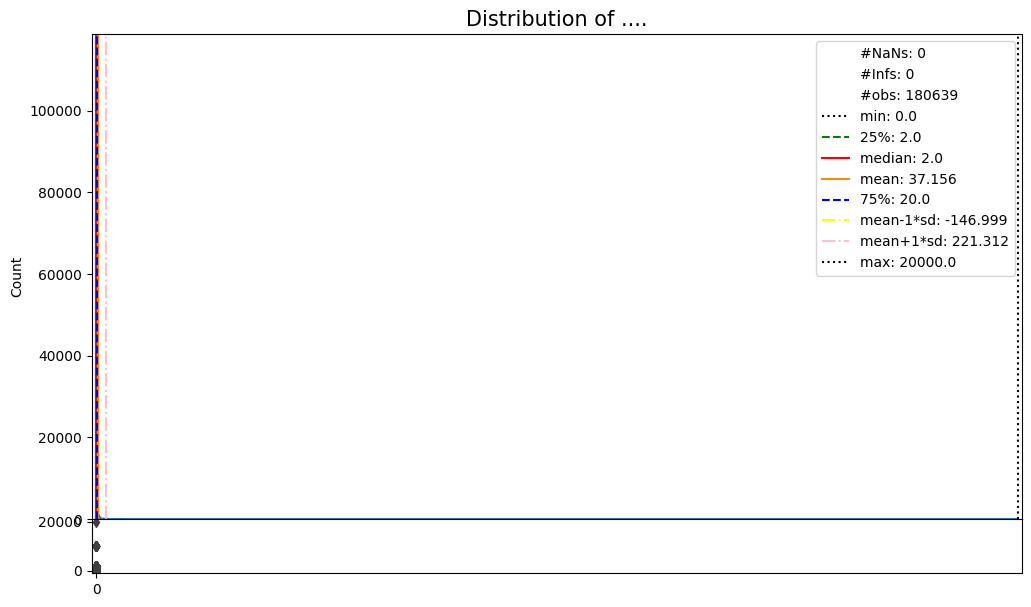

In [18]:

aml.Analysis.univariate_analysis(list(gamep_sub_df['total_fee_in_event']))


##### Observations
- Tournament A requires 2 player while Tournament B requires 4 player
- Tournament A is the most expensive entry fee, 
- Tournament D is the cheapest entry fee, 

- Tournament D has bigger win rate followed by A~C the B has the least Win rate


Data Time Range of various Dataset  
- demographic : 01/06/2020 - 01/01/2021  
- gameplay    : 01/12/2020 - 01/01/2021  
- balance     : 12/11/2020 - 07/01/2021  



### Balance & Current Balance

##### Basic Analysis

In [19]:
df_info = aml.DataPrimAnalysis(balan_df, True).run()


Overall dataset shape : (545835, 3)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,min,25%,50%,75%,max,%Missing
timestamp,0,datetime64,0,545835,2020-12-22 19:46:29.574292992+05:30,2020-11-12 11:58:44+05:30,2020-12-15 15:42:45.500000+05:30,2020-12-24 02:51:45+05:30,2020-12-30 17:22:02.500000+05:30,2021-01-07 05:59:52+05:30,0.0


____________| Number of feature/s which are Qualitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
uid,0,object,0,545835,21757,7457E894E1F7F1938E55802B964BDD27,2178,"[929A32AC6F614F29BEEA8601BDF0676C, 08B4F6235FC...",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
wallet_balance,0,float64,0,545835.0,68.867484,377.146944,-94.0,7.0,15.0,37.0,32699.0,0.0


In [20]:
df_info = aml.DataPrimAnalysis(balan_rec_df, True).run()


Overall dataset shape : (21757, 13)
____________| Number of feature/s which are Time based : 2 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,min,25%,50%,75%,max,%Missing
oldest_timestamp,0,datetime64,0,21757,2020-12-18 02:14:51.603943680+05:30,2020-11-12 11:58:44+05:30,2020-12-09 18:37:57+05:30,2020-12-18 20:41:07+05:30,2020-12-26 15:28:56+05:30,2021-01-01 05:06:35+05:30,0.0
recent_timestamp,0,datetime64,0,21757,2020-12-21 00:51:15.874155520+05:30,2020-11-14 17:08:58+05:30,2020-12-12 08:09:43+05:30,2020-12-22 19:25:41+05:30,2020-12-29 13:58:06+05:30,2021-01-07 05:59:52+05:30,0.0


____________| Number of feature/s which are Qualitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
uid,0,object,0,21757,21757,929A32AC6F614F29BEEA8601BDF0676C,1,"[929A32AC6F614F29BEEA8601BDF0676C, 08B4F6235FC...",0.0


____________| Number of feature/s which are Quantitative : 9 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
n_entries,0,int64,0,21757.0,25.087788,79.538235,1.000000,1.0,1.0,9.000000,2178.000000,0.0
wallet_balance_min,0,float64,0,21757.0,8.015903,5.017136,-94.000000,10.0,10.0,10.000000,10.000000,0.0
wallet_balance_max,0,float64,0,21757.0,46.098957,405.142378,5.000000,10.0,10.0,23.000000,32699.000000,0.0
wallet_balance_mean,0,float64,0,21757.0,17.182510,50.245796,-20.231353,10.0,10.0,12.594595,2701.780512,0.0
wallet_balance_25quantile,0,float64,0,21757.0,11.278922,15.247721,-31.000000,10.0,10.0,10.500000,1000.000000,0.0
wallet_balance_median,0,float64,0,21757.0,14.917084,31.060693,-22.000000,10.0,10.0,11.500000,1720.500000,0.0
wallet_balance_75quantile,0,float64,0,21757.0,20.712173,65.539377,-15.250000,10.0,10.0,14.250000,4375.000000,0.0
wallet_balance_std,0,float64,0,21757.0,8.736063,73.614888,0.000000,0.0,0.0,4.579365,5245.761710,0.0
wallet_balance_recent,0,float64,0,21757.0,12.468401,222.551837,-82.000000,10.0,10.0,10.000000,32608.000000,0.0


Some columns data is missing b/c of data type
len(temp)!= (len(temp_tim) + len(temp_cat) + len(temp_num))
13 != (2 + 1+ 9)
Columns not part of this: ['no_transaction']


##### distribution Analysis


Data is Missing in 0 rows constituting 0.0 % of the total rows.
Data is Infinity in 0 rows constituting 0.0 % of the total rows.
Metrics for "wallet_balance_recent": {'#obs': 21757, '#NaNs': 0, '#nan_cases_pct': 0.0, '#Infs': 0, '#inf_cases_pct': 0.0, 'min': -82.0, '25%': 10.0, 'median': 10.0, 'mean': 12.468400974399044, '75%': 10.0, 'max': 32608.0, 'sd': 222.5518366176179, 'mad': 7.04766086918737}


/Users/mohiiraj/Documents/VirtualEnv/macml_pyenv3.9/lib/python3.9/site-packages/amleet-0.1.0-py3.9.egg/amleet/aml06_data_analysis/df01_anlaysis.py:179: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  metrics_di['mad'] = var_ser.mad()


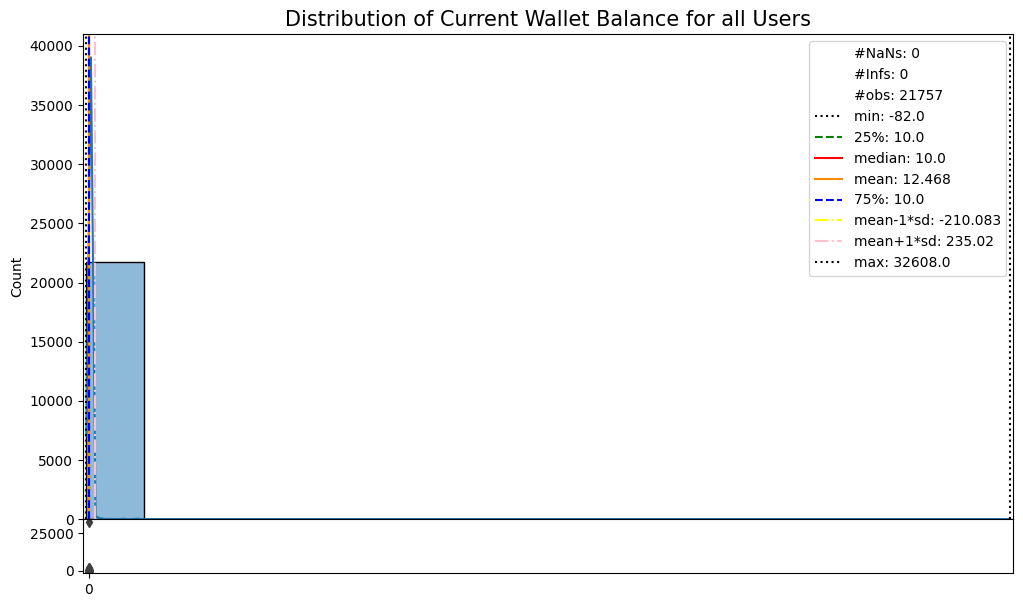

In [21]:
## Plotting the distribution of Users Wallet Balance
aml.Analysis.univariate_analysis(
    balan_rec_df.loc[:,'wallet_balance_recent'],
    plot_title='Distribution of Current Wallet Balance for all Users'
)


/Users/mohiiraj/Documents/VirtualEnv/macml_pyenv3.9/lib/python3.9/site-packages/amleet-0.1.0-py3.9.egg/amleet/aml06_data_analysis/df01_anlaysis.py:179: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  metrics_di['mad'] = var_ser.mad()


Data is Missing in 0 rows constituting 0.0 % of the total rows.
Data is Infinity in 0 rows constituting 0.0 % of the total rows.
Metrics for "wallet_balance_recent": {'#obs': 9546, '#NaNs': 0, '#nan_cases_pct': 0.0, '#Infs': 0, '#inf_cases_pct': 0.0, 'min': -82.0, '25%': 5.0, 'median': 10.0, 'mean': 15.627487953069348, '75%': 12.0, 'max': 32608.0, 'sd': 335.96846670160465, 'mad': 14.90007602211423}


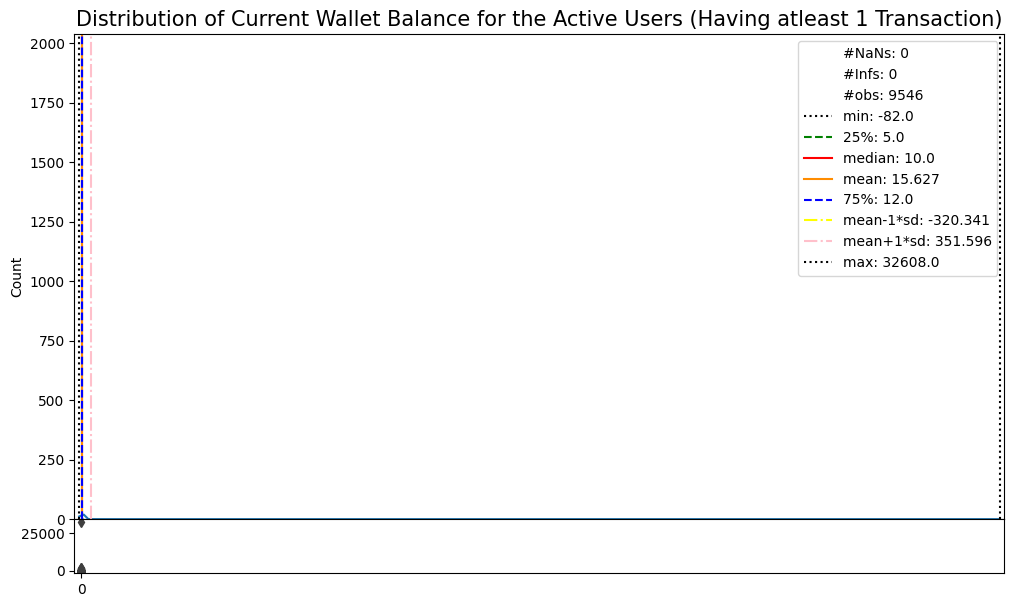

In [22]:
## Plotting the distribution of Active Users; having more than 1 Transaction
aml.Analysis.univariate_analysis(
    balan_rec_df.loc[~balan_rec_df['no_transaction'],'wallet_balance_recent'],
    plot_title='Distribution of Current Wallet Balance for the Active Users (Having atleast 1 Transaction)'
)


### Demographic

##### Basic Analysis

In [23]:
df_info = aml.DataPrimAnalysis(demog_rec_df, True).run()


Overall dataset shape : (21437, 14)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,min,25%,50%,75%,max,%Missing
installed_at,0,datetime64,0,21437,2020-12-16 13:59:39.005317888+05:30,2020-06-01 05:30:00+05:30,2020-12-08 19:53:19+05:30,2020-12-18 08:11:18+05:30,2020-12-26 11:11:54+05:30,2021-01-01 05:06:14+05:30,0.0


____________| Number of feature/s which are Qualitative : 12 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
uid,0,object,0,21437,21437,00024680E7379CABB31C1F07A424AB79,1,"[00024680E7379CABB31C1F07A424AB79, 0002D2CB922...",0.000000
connection_type,5,object,5,21437,5,Cellular,19915,"[Cable/DSL, Cellular, Corporate, Dialup, Missi...",0.023324
cpu_type,0,object,0,21437,4,arm64-v8a,16610,"[arm64-v8a, armeabi-v7a, x86, x86_64]",0.000000
device_manufacturer,0,object,0,21437,257,Xiaomi,5970,"[Xiaomi, vivo, Samsung, Oppo, Lenovo, Vivo, Re...",0.000000
isp,10,object,10,21437,302,Jio,11205,"[Mylink Services Pvt Ltd, Jio, Airtel, Vodafon...",0.046648
country,0,object,0,21437,25,in,21331,"[in, qa, lk, bd, pk, np, us, fr, gb, cz, tr, t...",0.000000
country_subdivision,74,object,74,21437,70,National Capital Territory of Delhi,2251,"[National Capital Territory of Delhi, Rajastha...",0.345198
city,552,object,552,21437,477,Jaipur,1761,"[New Delhi, Jaipur, Banka, Patna, Jodhpur, Che...",2.574987
postal_code,577,object,577,21437,1081,800001,1188,"[110001, 302001, 813109, 800001, 342001, 60000...",2.691608
language,0,object,0,21437,20,en,20679,"[en, hi, gu, mr, bn, kn, pa, tr, ta, gl, ar, u...",0.000000


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
network_type,0,int64,0,21437.0,10.270887,5.425392,0.0,13.0,13.0,13.0,19.0,0.0


##### BiVariate Analysis

In [24]:
aml.Analysis.value_counts_2_cols(demog_rec_df['device_type'], demog_rec_df['cpu_type'], True)


cpu_type,arm64-v8a,armeabi-v7a,x86,x86_64
device_type,,,,
phone,16510,4758,38,4
tablet,99,26,,1
tv,1,,,


In [25]:
aml.Analysis.value_counts_2_cols(demog_rec_df['device_type'], demog_rec_df['connection_type'], True)


connection_type,Cable/DSL,Cellular,Corporate,Dialup
device_type,,,,
phone,1410,19809,85,1
tablet,21,105,,
tv,,1,,


In [26]:
aml.Analysis.value_counts_2_cols(demog_rec_df['country'], demog_rec_df['connection_type'], True)


connection_type,Cable/DSL,Cellular,Corporate,Dialup
country,,,,
ae,2,,,
au,,,1,
ba,1,,,
bd,11,8,1,
ca,,,1,
ch,,,1,
cz,1,,,
de,,,1,
fr,,,3,


In [27]:
aml.Analysis.value_counts_2_cols(demog_rec_df['country'], demog_rec_df['language'], True)


language,ar,bh,bn,en,es,fa,gl,gu,hi,it,kn,ml,mr,ms,pa,ta,te,th,tr,ur
country,,,,,,,,,,,,,,,,,,,,
ae,,,,2,,,,,,,,,,,,,,,,
au,,,,1,,,,,,,,,,,,,,,,
ba,,,,1,,,,,,,,,,,,,,,,
bd,,,,21,,,,,,,,,,,,,,,,
ca,,,,1,,,,,,,,,,,,,,,,
ch,,,,1,,,,,,,,,,,,,,,,
cz,,,,1,,,,,,,,,,,,,,,,
de,,,,1,,,,,,,,,,,,,,,,
fr,,,,3,,,,,,,,,,,,,,,,


##### Check the number of active user wrt demographic

In [28]:
usr_cnt_wrt_state_df = demog_rec_df.groupby(by=['country', 'country_subdivision'])['uid'].count()
usr_cnt_wrt_state_df = usr_cnt_wrt_state_df.reset_index().rename(columns={'uid': '#user'})
usr_cnt_wrt_state_df = shp_gdf.set_index('st_nm').join(
    usr_cnt_wrt_state_df.set_index('country_subdivision'),
    how='left'
)

## Keeping county only of in here
# usr_cnt_wrt_state_df = usr_cnt_wrt_state_df.loc[usr_cnt_wrt_state_df['country']=='in',:]
usr_cnt_wrt_state_df['country'].fillna('in',inplace=True)
usr_cnt_wrt_state_df['#user'].fillna(0, inplace=True)

display(usr_cnt_wrt_state_df)


,geometry,country,#user
Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",in,0.0
Andhra Pradesh,"MULTIPOLYGON (((81.10380 17.82269, 81.10610 17...",in,287.0
Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",in,0.0
Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",in,216.0
Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",in,1906.0
Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",in,83.0
Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",in,220.0
Dadara & Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.10650...",in,0.0
Daman & Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",in,0.0
Goa,"MULTIPOLYGON (((74.11918 14.75344, 74.11350 14...",in,3.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


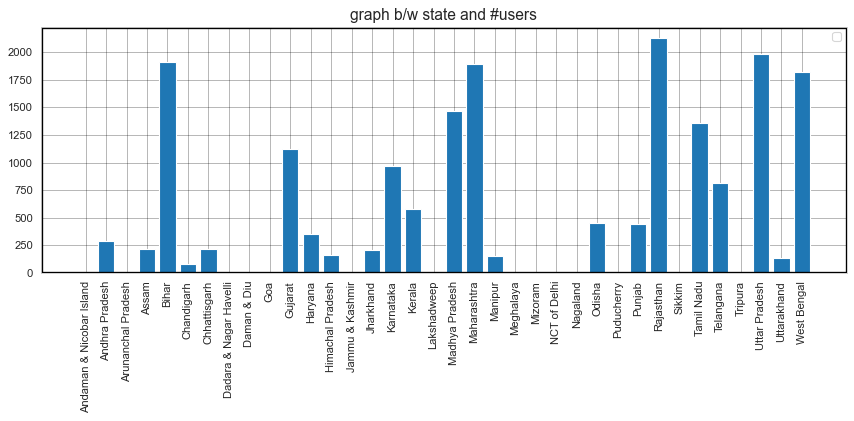

In [29]:
#### 
aml.plotBivariate_NumCat(
    pd.Series(usr_cnt_wrt_state_df.index, name='state'), 
    pd.Series(list(usr_cnt_wrt_state_df['#user']), name='#users'),
    plt_type='bar',
    rotate_x_tick=90
)


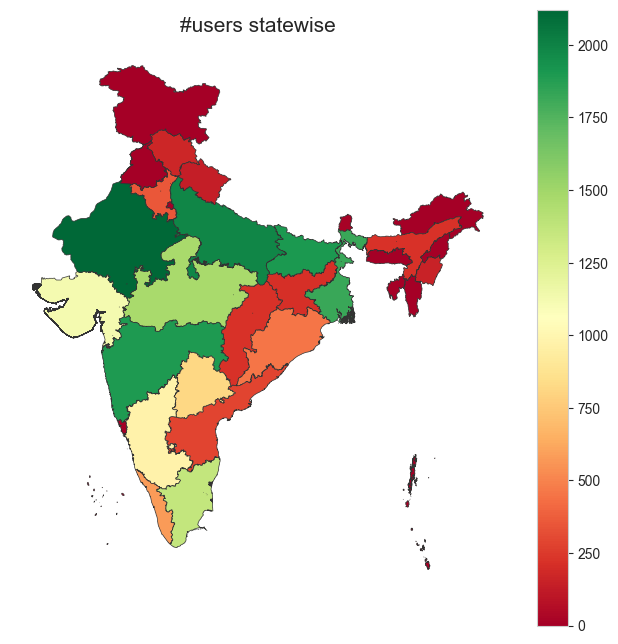

In [30]:
## Plotting the demographic india userbase
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.axis('off')
ax.set_title('#users statewise',fontdict={'fontsize':'15', 'fontweight':'3'})
fig = usr_cnt_wrt_state_df.plot(
    column='#user', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)


### Joining & Merging Datasets


In [31]:

# demog_df ## user details
# balan_rec_df ## user account balance data
gamep_df ## User engagement data

# user_merge_df




,uid,eventtime,entry_fee,win_loss,winnings,tournament_type,num_players,oot_holdout
0,90976392B3AA5DB94D134936B765879E,2020-12-07 04:10:30.194000+05:30,0.0,W,0.1,D,4,False
1,7457E894E1F7F1938E55802B964BDD27,2020-12-07 02:01:47.669000+05:30,10.0,W,17.0,A,2,False
2,52E43F75D7393581C4E2C5EDC7D24671,2020-12-04 00:51:02.845000+05:30,35.0,L,0.0,A,2,False
3,5736C06C66C6BC7036CCE9804F54A57C,2020-12-12 18:44:35.873000+05:30,10.0,W,32.0,B,4,False
4,5FE2DDA792CA72F731D818A5ECC5F1EB,2020-12-12 18:39:34.193000+05:30,25.0,W,42.0,A,2,False
...,...,...,...,...,...,...,...,...
307661,57711CD771B0B4E54B141FD7A1434B20,2020-12-30 07:23:39.487000+05:30,10.0,L,0.0,B,4,True
307662,A2923F83BA0092B3DF2651B4254A8A7B,2020-12-23 18:06:23.420000+05:30,5.0,L,0.0,D,4,False
307663,A2923F83BA0092B3DF2651B4254A8A7B,2020-12-23 18:27:36.461000+05:30,5.0,W,5.5,D,4,False
307664,DD56A62666312D869EC37FF6210C237B,2020-12-23 19:22:36.726000+05:30,0.0,W,0.3,D,4,False


In [32]:

print(len(demog_rec_df['uid'].unique()), len(balan_rec_df['uid'].unique()))


21437 21757
